## 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

- First, load the dataset from the weatherinszeged table from Thinkful's database.
- Next, Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
- Finally, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

temperature_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [130]:
temperature_df.head(3)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.


In [131]:
temperature_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


In [132]:
# Missing value number and type detection

for column_name in temperature_df.columns[3:11]:
    nan_list = []
    print("Problematic values: {}".format(column_name))
    for idx, value in enumerate(temperature_df[column_name]):
        if pd.isna(value):
            nan_list.append(str(value))
    print(len(nan_list), ': ', set(nan_list))

Problematic values: temperature
0 :  set()
Problematic values: apparenttemperature
0 :  set()
Problematic values: humidity
0 :  set()
Problematic values: windspeed
0 :  set()
Problematic values: windbearing
0 :  set()
Problematic values: visibility
0 :  set()
Problematic values: loudcover
0 :  set()
Problematic values: pressure
0 :  set()


- ### Distribution of our target variable: temperature

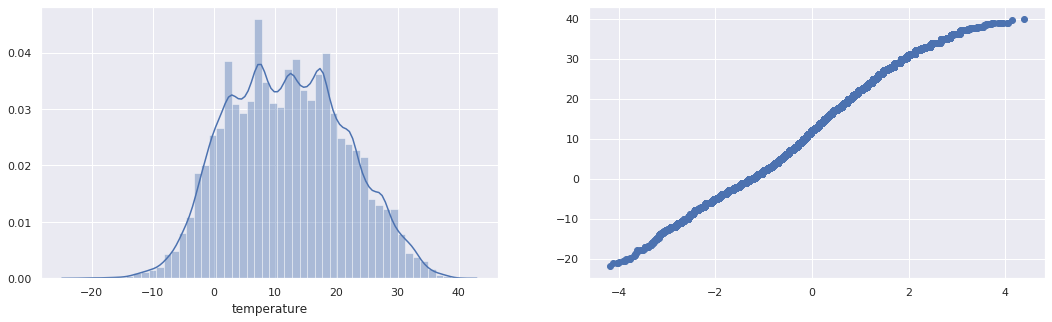

In [133]:
sns.set(style='darkgrid')

# Checking for normality in the target variable 'saleprice', visually, using a qq plot
norm = np.random.normal(0, 1, len(temperature_df))

# Sorting the values in ascending order.
norm.sort()

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.distplot(temperature_df.temperature)

plt.subplot(1,2,2)
plt.scatter(norm, temperature_df.temperature.sort_values())
plt.show()

> # Build a regression model using OLS.

In [137]:
# Y is the target variable
Y = temperature_df.temperature

# X are the explanatory variables
X = temperature_df[['humidity','windspeed','windbearing','visibility','pressure']]

# We create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

# Inspect the results
print('The coefficients: {}'.format(lrm.coef_))
print('\nThe intercept: {}'.format(lrm.intercept_))

The coefficients: [-2.91526993e+01 -2.05732449e-01  3.26860785e-03  4.26211115e-01
 -1.65688320e-03]

The intercept: 32.22027226986857


In [139]:
# Using the statsmodels summary

# We need to manually add a constant in statsmodels' sm
X_stats = sm.add_constant(X)

results = sm.OLS(Y,X_stats).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.582e+04
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        19:00:09   Log-Likelihood:            -3.2564e+05
No. Observations:               96453   AIC:                         6.513e+05
Df Residuals:                   96447   BIC:                         6.514e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          32.2203      0.240    134.131      0.000      31.749      32.691
humidity      -29.1527      0.128   -227.236      0.000     -29.404     -28.901
windspeed      -0.2057      0.003    -60.365      0.000      -0.212      -0.199
windbearing     0.0033      0.000     15.289      0.000       0.003       0.004
visibility      0.4262      0.006     72.566      0.000       0.415       0.438
pressure       -0.0017      0.000     -8.471      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     3452.090   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3877.739
Skew:                          -0.463   Prob(JB):                         0.00
Kurtosis:                       3.326   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> #  Check that the model meets the Gauss-Markov Conditions 
- see [Gauss-Markov Assumptions](https://www.youtube.com/watch?v=NjTpHS5xLP8) on <i>Youtube</i> and [Verifying the Assumptions of Linear Regression in Python and R](https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0) at <i>Towards Data Science</i> for more info.
- <font color='blue'>BLUE</font> (Best Linear Unbiased Estimator) of the coefficients is the ordinary least squares (OLS) estimator provided that the conditions are met. 'Best’ in <font color='blue'>BLUE</font> means resulting in the lowest variance of the estimate, in comparison to other unbiased, linear estimators.

### 1. Linearity of the model in its coefficients / Linearity in parameters
- To detect nonlinearity one can visually inspect plots of observed values vs. predicted values. Observing a ‘bowed’ pattern indicates that the model makes systematic errors whenever it is making unusually large or small predictions.

In [140]:
# predictions of the linear regression
predictions = lrm.predict(X)

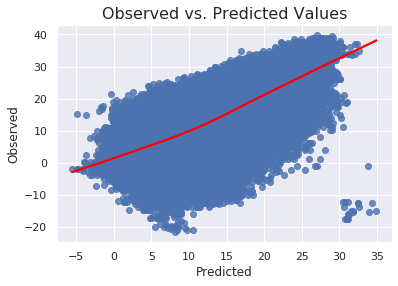

In [76]:
sns.regplot(predictions, Y, lowess=True, line_kws={'color': 'red'})
plt.title('Observed vs. Predicted Values', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.show()


#### BEWARE: This cell takes a long time to run ####

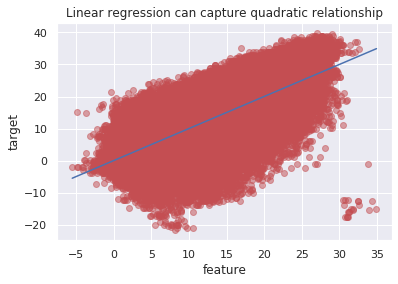

In [141]:
plt.scatter(predictions,Y, color='r', alpha=.5)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.plot(np.unique(predictions), np.poly1d(np.polyfit(predictions, Y, 1))(np.unique(predictions)))
plt.show()

#### Potential solutions:

- non-linear transformations to dependent/independent variables
- adding extra features which are a transformation of the already used ones (for example squared version)
- adding features that were not considered before

#### Implications if condition not met:
- Fitting a linear model to data with non-linear patterns results in serious prediction errors, especially out-of-sample (data not used for training the model).

### 2. Expectation (mean) of residuals is zero
- algebraically, E{εi} = 0, i = 1, . . . , N

In [142]:
errors = Y - predictions

# Should produce a number very close to zero
print("Mean of the errors: {}".format(np.mean(errors)))

Mean of the errors: -3.3002928433591997e-16


#### Implications if condition not met:

- This assumption is not held if you forget to include the constant term in your model. <font color='red'>This is why we said that you should always include a constant in your model.</font> As long as we include a constant in a model, we shouldn't be worried about this assumption as the constant will force the error terms to be zero on average.

### 3. No / low multicollinearity

- The features should be linearly independent. Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. In other words, we should not be able to use a linear model to accurately predict one feature using another one.
- Watch out for is the ‘dummy variable trap’ (drop_first=True)

In [144]:
X.corr()

,humidity,windspeed,windbearing,visibility,pressure
humidity,1.000,-0.225,0.001,-0.369,0.005
windspeed,-0.225,1.000,0.104,0.101,-0.049
windbearing,0.001,0.104,1.000,0.048,-0.012
visibility,-0.369,0.101,0.048,1.000,0.060
pressure,0.005,-0.049,-0.012,0.060,1.000


#### Implications if condition not met:
- If we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

### 4. Homoscedasticity (equal variance) of errors/residuals

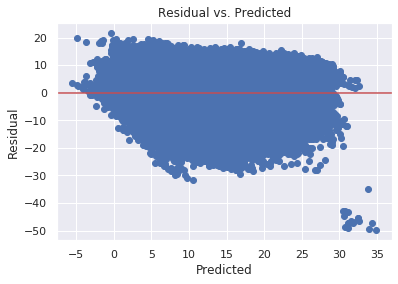

In [145]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='r')
plt.title('Residual vs. Predicted')
plt.show()

In [146]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 947.077 and p value is 5.73e-208
Levene test statistic value is 613.099 and p value is 3.86e-135


- ### The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are <i>heteroscedastic</i>.

#### Potential solutions:
- log transformation of the dependent variable
- in case of time series, deflating a series if it concerns monetary value
- using ARCH (auto-regressive conditional heteroscedasticity) models to model the error variance. An example might be stock market, where data can exhibit periods of increased or decreased volatility over time (volatility clustering, see this article for more information)

#### Implications if conditions not met:
- When residuals do not have constant variance (they exhibit heteroscedasticity), it is difficult to determine the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide/narrow. For example, if the variance of the residuals is increasing over time, confidence intervals for out-of-sample predictions will be unrealistically narrow.

### 5. No autocorrelation of errors/residuals
- error terms should be uncorrelated with one another

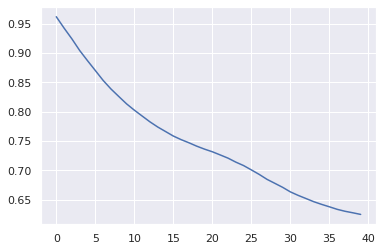

In [198]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### 6. The features and residuals are uncorrelated

In [199]:
from scipy.stats.stats import pearsonr

for column in X.columns:
    corr_test = pearsonr(X[column], errors)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')


Variable: humidity --- correlation: 0.0000, p-value: 1.0000
Variable: windspeed --- correlation: 0.0000, p-value: 1.0000
Variable: windbearing --- correlation: 0.0000, p-value: 1.0000
Variable: visibility --- correlation: -0.0000, p-value: 1.0000
Variable: pressure --- correlation: 0.0000, p-value: 1.0000


### Other assumptions

1. The number of observations must be greater than the number of features

In [209]:
# Number of rows > number of columns?

temperature_df.shape[0] > len(X.columns)

True

2. There must be some variability in features

In [208]:
X.apply(np.var, axis=0)

humidity          0.038
windspeed        47.797
windbearing   11531.081
visibility       17.574
pressure      13681.817
dtype: float64

## <font color=red>Normality of the errors</font>
- Specifically, normality of errors is not required to apply OLS to a linear regression model, but in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed.

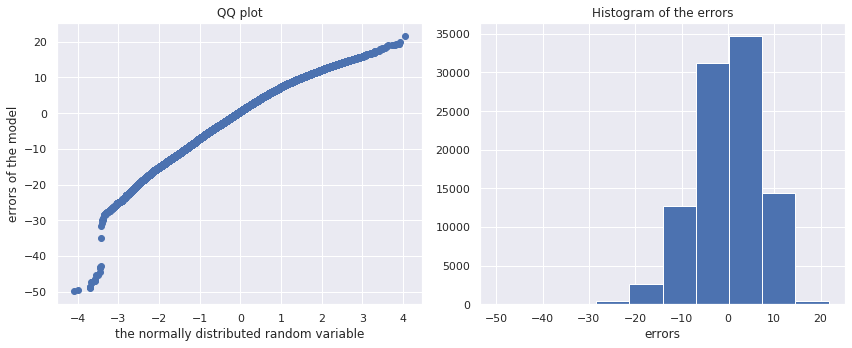

In [210]:
norm = np.random.normal(0,1, len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(norm), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()